# Movie Recommendation Using NLP

### Import necessary libraries

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import io
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from skimage import io
from IPython.display import clear_output

## Data Preprocessing

In [18]:
# read the dataset https://www.kaggle.com/datasets/akshaypawar7/millions-of-movies
df = pd.read_csv('movies.csv')

In [21]:
# drop movies that have a short description
df['word_count'] = df['overview'].apply(lambda x: len(str(x).split()))
df = df[df['word_count'] >= 50]
df.drop('word_count', axis=1, inplace=True)

In [22]:
# drop all duplicates
df.drop_duplicates(subset=['title', 'release_date'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [23]:
# Drop rows with missing poster_path
df.dropna(subset=['poster_path'], inplace=True)

In [24]:
# fill empty cells
df.fillna(value={i: '' for i in ['overview', 'genres', 'keywords', 'credits']}, inplace=True)

In [25]:
# lambda function to preprocess string data
strOp= lambda x: ' '.join(x.split('-'))

In [26]:
# add keywords, genres and credits to overview for full information
df.overview = df.overview + df.keywords.apply(strOp) + df.genres.apply(strOp) + df.credits.apply(lambda x: ' '.join(x.replace(' ', '').split('-')[:3]))
# example
# df.overview[0]

'Set more than a decade after the events of the first film learn the story of the Sully family (Jake Neytiri and their kids) the trouble that follows them the lengths they go to keep each other safe the battles they fight to stay alive and the tragedies they endure.loss of loved one dying and death alien life form resurrection sequel dysfunctional family alien planet distant future adopted child rebirth family dynamics adopted son stronger villain warScience Fiction Adventure ActionSamWorthington ZoeSaldaña SigourneyWeaver'

### Initialize the TF-IDF Vectorizer to transform text data into vectors

#### only run these lines once!

In [27]:
# TF-IDF Vectorizer to transform words into numbers and remove common english words like 'the'
tfidf = TfidfVectorizer(stop_words='english')

In [28]:
# transform overview data with TF-IDF vectorizer to create matrix
tfidf_matrix = tfidf.fit_transform(df['overview'])

In [29]:
#display some columns with vectorized words
display(pd.DataFrame(
    tfidf_matrix[:5, 10000:10005].toarray(),
    columns= tfidf.get_feature_names_out()[10000:10005],
    index = df.title[:5]).round())

print(tfidf_matrix.shape)
# over 970000 different words used to describe all movies

,adventurebrandonsemenuk,adventurebreckinmeyer,adventurebrendanguymurphy,adventurebrettmaxworthy,adventurebriankeith
title,,,,,
Avatar: The Way of Water,0.0,0.0,0.0,0.0,0.0
Ant-Man and the Wasp: Quantumania,0.0,0.0,0.0,0.0,0.0
Creed III,0.0,0.0,0.0,0.0,0.0
Knock at the Cabin,0.0,0.0,0.0,0.0,0.0
Black Panther: Wakanda Forever,0.0,0.0,0.0,0.0,0.0


(157230, 440760)


## Movie Recommendation

### Initialize the recommendation function

In [34]:
def get_recommendation(user_input):
    # Vectorize user input
    vectorized_input = tfidf.transform([user_input])

    # Calculate cosine similarity between user input and movie overviews
    similarity_scores = cosine_similarity(vectorized_input, tfidf_matrix)

    # Get the indices of top similar movies
    top_indices = similarity_scores.argsort()[0][::-1][:3]

    # Retrieve the top recommended movies
    recommended_movies = df.iloc[top_indices]

    # Display movie posters for the recommended movies
    fig, ax = plt.subplots(1, 3, figsize=(15, 20))
    ax = ax.flatten()
    for i, j in enumerate(recommended_movies.poster_path):
        try:
            ax[i].axis('off')
            ax[i].set_title(recommended_movies.iloc[i].title, fontsize=22)
            a = io.imread(f'https://image.tmdb.org/t/p/w500/{j}')
            ax[i].imshow(a)
        except:
            pass
    fig.tight_layout()
    plt.show()
    print()
    print(recommended_movies.title, recommended_movies.overview)

### Ask for User Input

In [35]:
# replace the string with a description of the type of movie you'd like to see
user_input = "marvel superhero fight action"

### Show Recommendations

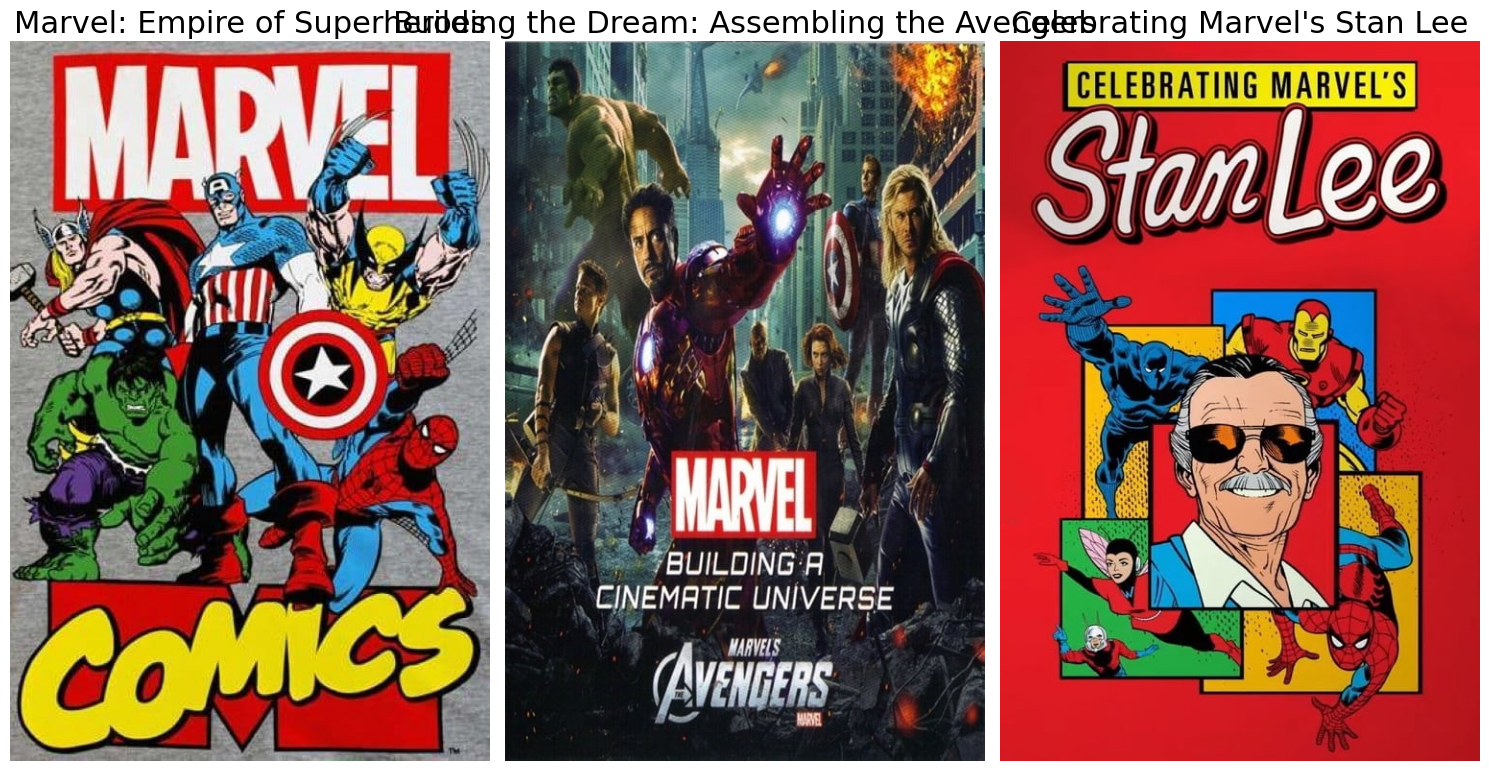


73625                  Marvel: Empire of Superheroes
1361     Building the Dream: Assembling the Avengers
12205                  Celebrating Marvel's Stan Lee
Name: title, dtype: object 73625    Marvel and its rival DC Comics were long locke...
1361     Witness Marvel's epic journey from its comic b...
12205    Filmed in part in front of a live audience at ...
Name: overview, dtype: object


In [36]:
get_recommendation(user_input)